In [29]:
from mesh import *

from VPINN_tri_final import *

from PROBDEF import PROBDEF

import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import logging; logging.getLogger('tensorflow').setLevel(logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

import gmsh_worker as gw
from MeshLib import MeshLib as ml

# importing probdef 
pb = PROBDEF()

In [30]:
# Get quad pairs
from numpy.polynomial import legendre

def get_quad_rule(n: int):
    # Degree of the Legendre polynomial (number of nodes - 1)

    # Nodes and weights for Gauss-Legendre quadrature
    nodes, weights = legendre.leggauss(n + 1)



    nodes=(nodes+1.0)/2.0


    # Nodes=np.array([nodes],dtype=np_type)

    Weights=np.array([weights],dtype=np_type)
    w = Weights.T @ Weights
    w = np.reshape(w, (-1,1))


    x, y =np.meshgrid(nodes,nodes)


    x = x.flatten()
    y = y.flatten()
 



    xy=np.array([x,y]).T


    return xy, w/4

def L2_error(xy, w):
    
    u_NN = vp.NN_imposeBC(xy)

    # Find the exact solution
    u_ex = pb.u_exact_np(xy[:,0], xy[:,1])
    u_ex = np.reshape(u_ex, (-1,1))

    integrand = (u_ex - u_NN)**2


    # Find the difference between exact and NN 
    # return (u_ex - u_NN)**2

    return np.sqrt(np.sum(w*integrand))

def semi_H1_error(xy, w):

    # Find the gradient of the exact solution
    grad_ex = np.array([pb.dudx(xy[:,0], xy[:,1]), pb.dudy(xy[:,0], xy[:,1])],dtype=np_type).T


    # Find the gradient of the NN solution
    grad_NN = vp.eval_grad_NN_BC(tf.constant(xy, dtype=tf_type))

    


    # Find the difference between exact and NN 
    pw_diff = grad_ex - grad_NN

    pw_diff = tf.reduce_sum(tf.square(pw_diff),axis=1)

    pw_diff=tf.reshape(pw_diff,(-1,1))


    return np.sqrt(np.sum(pw_diff*w))

In [31]:
def restart_model():
    model = tfk.models.Sequential()
    model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))
    return model

In [32]:
geo_file = './unit_square_triangles'
worker = gw.gmsh_worker(geo_file)
worker.generate_parallel_chain(False, False, False)

# seed for reproducibility
initializer = tf.keras.initializers.GlorotUniform(seed=1000)

# mesh init
domain = ((0, 0), (1, 0), (1, 1), (0, 1))

# order of test function 
N_test = 1
params = {'scheme': 'VPINNs','N_test':N_test}

xy, w = get_quad_rule(30)

H1 = []
L2 = []
semi = []
h = []

for refinement in [0,1,2,3]:
    model = restart_model()
    mesh, _ = ml.take_parallel_mesh_chain(worker.chain[refinement],worker.chain[-1], 'DDDD')
    mesh = mesh.convert_to_dict()
    vp=VPINN(pb,params,mesh,False,model)
    history=vp.train(15000, 0.00005)
    # history=vp.train(10000, 0.0005)
    # ml.compare(worker.chain[refinement],worker.chain[refinement])


    L2_error_=L2_error(xy,w)


    semi_H1_err = semi_H1_error(xy,w)
    #H1_err = np.sqrt(L2_error**2 + semi_H1_err**2)

    #H1.append(H1_err)
    semi.append(semi_H1_err)
    L2.append(L2_error_)
    a, b = mesh['h_max'], mesh['h_min']
    h.append(0.5*a + 0.5*b)
    
    







-->mesh : 
     n_triangles :  4
     n_vertices  :  5
     n_edges     :  8
     h_max           :  1.0
     h_min           :  0.7071067811865476
-->test_fun      : 
     order       :  1
     dof         :  1


2023-12-28 11:43:15.815820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-28 11:43:15.821031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.7905848660 time: 2.2271006107330322
Iteration: 10 loss: 0.5956421734 time: 0.057094573974609375
Iteration: 20 loss: 0.4302140082 time: 0.05663323402404785
Iteration: 30 loss: 0.2966267255 time: 0.05653858184814453
Iteration: 40 loss: 0.1942367903 time: 0.05179786682128906
Iteration: 50 loss: 0.1200239432 time: 0.055130720138549805
Iteration: 60 loss: 0.0694275524 time: 0.0527799129486084
Iteration: 70 loss: 0.0372254270 time: 0.05182027816772461
Iteration: 80 loss: 0.0182795839 time: 0.0525202751159668
Iteration: 90 loss: 0.0080978251 time: 0.054486989974975586
Iteration: 100 loss: 0.0031715366 time: 0.04995870590209961
Iteration: 110 loss: 0.0010653537 time: 0.041959524154663086
Iteration: 120 loss: 0.0002910327 time: 0.0395052433013916
Iteration: 130 loss: 0.0000575956 time: 0.04500937461853027
Iteration: 140 loss: 0.0000057115 time: 0.041318416595458984
Iteration: 150 loss: 0.0000000046 time: 0.041175127029418945
Iteration: 160 loss: 0.0000008784 time: 0.0338604

2023-12-28 11:44:15.153765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-28 11:44:15.157930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.1100002730 time: 3.3562488555908203
Iteration: 10 loss: 0.0882126888 time: 0.09075522422790527
Iteration: 20 loss: 0.0697115218 time: 0.09273886680603027
Iteration: 30 loss: 0.0546825841 time: 0.0969381332397461
Iteration: 40 loss: 0.0430141998 time: 0.08442258834838867
Iteration: 50 loss: 0.0343307376 time: 0.0957791805267334
Iteration: 60 loss: 0.0280925175 time: 0.08499789237976074
Iteration: 70 loss: 0.0237064616 time: 0.09234428405761719
Iteration: 80 loss: 0.0206183735 time: 0.08205056190490723
Iteration: 90 loss: 0.0183771221 time: 0.08803582191467285
Iteration: 100 loss: 0.0166577159 time: 0.09089994430541992
Iteration: 110 loss: 0.0152502235 time: 0.0788724422454834
Iteration: 120 loss: 0.0140317960 time: 0.07854986190795898
Iteration: 130 loss: 0.0129362480 time: 0.07275652885437012
Iteration: 140 loss: 0.0119296525 time: 0.07467770576477051
Iteration: 150 loss: 0.0109944384 time: 0.07689380645751953
Iteration: 160 loss: 0.0101206704 time: 0.0682964324951

2023-12-28 11:46:08.325349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-28 11:46:08.329488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.0085826756 time: 11.898211240768433
Iteration: 10 loss: 0.0071611359 time: 0.23240399360656738
Iteration: 20 loss: 0.0059404160 time: 0.22037601470947266
Iteration: 30 loss: 0.0049304590 time: 0.21485352516174316
Iteration: 40 loss: 0.0041230936 time: 0.22535228729248047
Iteration: 50 loss: 0.0034958106 time: 0.22911977767944336
Iteration: 60 loss: 0.0030176763 time: 0.21701455116271973
Iteration: 70 loss: 0.0026553762 time: 0.22573089599609375
Iteration: 80 loss: 0.0023779999 time: 0.21624040603637695
Iteration: 90 loss: 0.0021600404 time: 0.21898531913757324
Iteration: 100 loss: 0.0019824547 time: 0.21654701232910156
Iteration: 110 loss: 0.0018322063 time: 0.19746685028076172
Iteration: 120 loss: 0.0017009833 time: 0.19463872909545898
Iteration: 130 loss: 0.0015837352 time: 0.18590021133422852
Iteration: 140 loss: 0.0014774445 time: 0.18724370002746582
Iteration: 150 loss: 0.0013802722 time: 0.19594573974609375
Iteration: 160 loss: 0.0012910416 time: 0.1844227313

2023-12-28 11:51:15.439574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-28 11:51:15.443265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.0005437941 time: 37.59074831008911
Iteration: 10 loss: 0.0004588096 time: 0.4724540710449219
Iteration: 20 loss: 0.0003852494 time: 0.4412970542907715
Iteration: 30 loss: 0.0003238366 time: 0.4315817356109619
Iteration: 40 loss: 0.0002742001 time: 0.43503713607788086
Iteration: 50 loss: 0.0002350905 time: 0.44859933853149414
Iteration: 60 loss: 0.0002047677 time: 0.43678903579711914
Iteration: 70 loss: 0.0001813453 time: 0.4439072608947754
Iteration: 80 loss: 0.0001630702 time: 0.44216060638427734
Iteration: 90 loss: 0.0001484875 time: 0.44797706604003906
Iteration: 100 loss: 0.0001364949 time: 0.4495270252227783
Iteration: 110 loss: 0.0001263194 time: 0.4411349296569824
Iteration: 120 loss: 0.0001174522 time: 0.43564605712890625
Iteration: 130 loss: 0.0001095725 time: 0.43149542808532715
Iteration: 140 loss: 0.0001024813 time: 0.43908166885375977
Iteration: 150 loss: 0.0000960535 time: 0.45523500442504883
Iteration: 160 loss: 0.0000902072 time: 0.4323160648345947


In [33]:
h = np.array(h)

#H1 = np.array(H1)
L2 = np.array(L2)
semi = np.array(semi)

semi rate: 3.092049282417616
L2 rate: 3.802529459820002


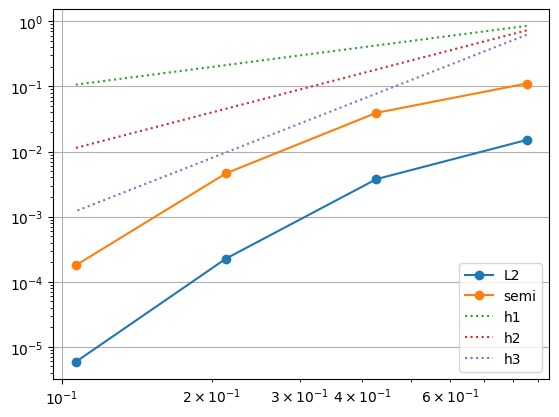

In [34]:
# slope_H1, intercept_H1 = np.polyfit(h, H1, 1)
# slope_L2, intercept_L2 = np.polyfit(h, L2, 1)

coeffs = np.polyfit(np.log10(h), np.log10(semi), 1)
polynomial = np.poly1d(coeffs)
log10_H1_fit = polynomial(np.log10(h))

print(f"semi rate: {coeffs[0]}")

coeffs = np.polyfit(np.log10(h), np.log10(L2), 1)
polynomial = np.poly1d(coeffs)
log10_L2_fit = polynomial(np.log10(h))

print(f"L2 rate: {coeffs[0]}")

#plt.loglog(h, H1, marker='o', label='H1')
plt.loglog(h, L2, marker='o', label='L2')
plt.loglog(h, semi, marker='o', label='semi')
#plt.loglog(h, 10**log10_H1_fit)
# plt.loglog(h, 10**log10_L2_fit)
plt.loglog(h, h, linestyle=':', label='h1')
plt.loglog(h, h*h, linestyle=':', label='h2')
plt.loglog(h, h*h*h, linestyle=':', label='h3')
plt.grid()
plt.legend()